In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import torch
import matplotlib.pyplot as plt
import ratsimulator

### Initialise the square box environment and a virtual rat agent placed in the environment

In [66]:
environment = ratsimulator.Environment.Rectangle(boxsize=(2.2, 2.2), soft_boundary=0.03)
agent = ratsimulator.Agent(environment) # use default walker agent

Singular matrix
Singular matrix


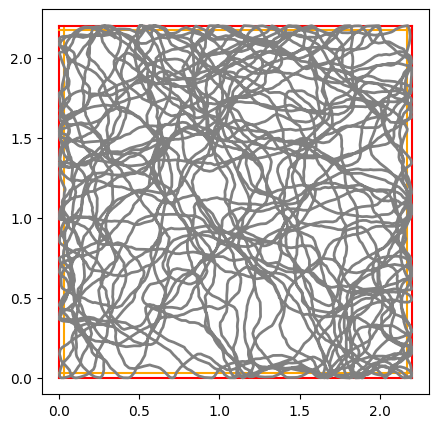

In [67]:
# ----------------------------------
# Try running this cell multiple times to see different trajectories
# ----------------------------------

agent.reset() # reset agent to initial random position and remove any trajectory history
for _ in range(10000):
    agent.step()

# get agent trajectory
velocities = agent.velocities # we don't use this here, but we show it for completeness
positions = agent.positions

# plot the board
fig,ax = plt.subplots(figsize=(5,5))
environment.plot_board(ax)
ax.axis('equal')

# plot the trajectory
ax.plot(*positions.T, color='grey', linewidth=2)

### Initialise Place cells

In [68]:
from PlaceCells import PlaceCells

In [69]:
place_cells = PlaceCells(environment, DoG=True) # default parameters are fine

(positions, place_cell_id) = torch.Size([10001, 512])


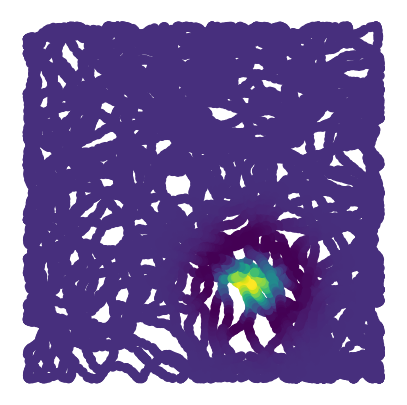

In [70]:
# ----------------------------------
# Show an example place cell activity for the trajectory
# Try increasing trajectory length to see more place cell activity
# ----------------------------------

# get place cell activities for the trajectory.
# PlaceCells assume tensor input, so we convert positions to a tensor
pc_activities = place_cells.softmax_response(torch.tensor(positions))
print("(positions, place_cell_id) =", pc_activities.shape)
# plot an example place cell activity
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(*positions.T, c=pc_activities[:,0].numpy(), cmap='viridis')
ax.axis('equal')
ax.axis('off');


### Demonstrate the dataloader

In [71]:
from dataloader import Dataset

In [72]:
# set num_samples essentially infinite, since data is generated on the fly anyway
dataset = Dataset(agent, place_cells, num_samples=int(1e+14), seq_len=20)
# you can get example data from the dataset like this:
velocities, init_pc_positions, labels, positions = dataset[0]
print("---> Single example data shapes: <---")
print("velocities =", velocities.shape)
print("init_pc_positions =", init_pc_positions.shape)
print("labels =", labels.shape)
print("positions =", positions.shape)
# Create dataloader object (allows us to iterate over the dataset in batches and using multiple workers)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=200, num_workers=16) # -----> choose num_workers based on your system <-----
print("--------------------")
print("---> Batched data shapes: <---")
for velocities, init_pc_positions, labels, positions in dataloader:
    print("velocities =", velocities.shape)
    print("init_pc_positions =", init_pc_positions.shape)
    print("labels =", labels.shape)
    print("positions =", positions.shape)
    break # break after first batch for demonstration purposes

---> Single example data shapes: <---
velocities = torch.Size([20, 2])
init_pc_positions = torch.Size([512])
labels = torch.Size([20, 512])
positions = torch.Size([21, 2])
--------------------
---> Batched data shapes: <---


velocities = torch.Size([200, 20, 2])
init_pc_positions = torch.Size([200, 512])
labels = torch.Size([200, 20, 512])
positions = torch.Size([200, 21, 2])


### Instantiate model

In [89]:
from SorscherRNN_original import SorscherRNN

In [90]:
model = SorscherRNN() # default parameters are fine
loss_history = [] # we'll use this to plot the loss over time
# move model to GPU if available
if torch.cuda.is_available():
    model = model.to('cuda')

In [91]:
# Demonstrate a a forward pass with the model for a single input
# its the first two elements (velocity and initial place cell activity) of a dataset instance
predictions = model(*dataset[0][:2])
print("predictions =", predictions.shape)

predictions = torch.Size([1, 20, 512])


### Train model
OBS! Consider creating code for saving and loading model - training takes a bit of time.
(the trajectory generation is the bottle neck.. sorry :) - using more processes speeds this up, but is not really an ideal solution.

In [92]:
from tqdm import tqdm

num_train_steps = int(420) # number of training steps used by Sorscher et al.
progress_bar = tqdm(enumerate(dataloader), total=num_train_steps)
for i, (v, p0, labels, _) in progress_bar:
    loss = model.train_step(v, p0, labels)
    # Update the description and postfix of the progress bar every 100 iterations
    if i % 100 == 0:
        progress_bar.set_description(f"Step {i+1}")
        progress_bar.set_postfix({"loss": f"{loss:.4f}"})
        loss_history.append(loss)
    if i > num_train_steps:
        break

Step 401: : 421it [04:12,  1.67it/s, loss=6.2394]                       


Text(0, 0.5, 'Loss')

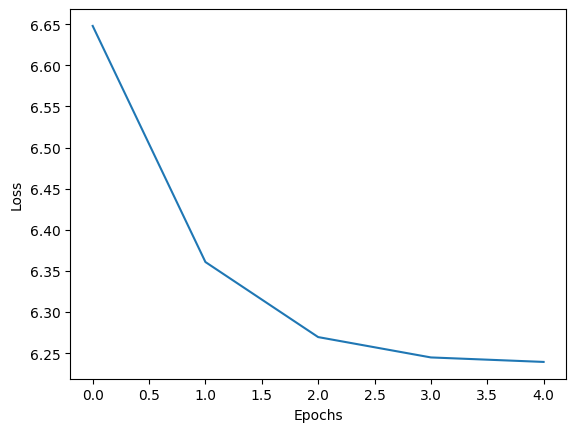

In [93]:
import numpy as np
plt.plot(loss_history)
plt.xlabel("Epochs")
#plt.xticks(np.linspace(0,num_train_steps*100, len(loss_history)), np.linspace(0,num_train_steps, len(loss_history)))
plt.ylabel("Loss")

In [106]:
import numpy as np

# number of spatial samples across mini-batch and sequence length
nsamples = 100000
recurrent_activities = []
stacked_positions = []
for i, (v, p0, _, positions) in enumerate(dataloader):
    recurrent_activities.append(model.forward(v, p0).cpu().detach().numpy())
    stacked_positions.append(positions[:,1:].cpu().detach().numpy())
    if i*dataloader.batch_size*dataset.seq_len > nsamples:
        break
# stack runs in mini-batch dimension
recurrent_activities = np.concatenate(recurrent_activities, axis=0)
stacked_positions = np.concatenate(stacked_positions, axis=0)
print("recurrent_activities =", recurrent_activities.shape)
print("stacked_positions =", stacked_positions.shape)
# flatten mini-batch and sequence length dimensions
recurrent_activities = recurrent_activities.reshape(-1, recurrent_activities.shape[-1])
stacked_positions = stacked_positions.reshape(-1, stacked_positions.shape[-1])
print("recurrent_activities =", recurrent_activities.shape)
print("stacked_positions =", stacked_positions.shape)

/Users/mkkvalsu/python_envs/grid_cells_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


recurrent_activities = (5400, 20, 512)
stacked_positions = (5400, 20, 2)
recurrent_activities = (108000, 512)
stacked_positions = (108000, 2)


In [107]:
# Now we have positions and the correpsonding recurrent activities for each position
# We can use this to compute the firing field for some example recurrent cells

# for this we will use the scipy.stats.binned_statistic_2d function, and a custom
# multiimshow function that we provide in the utils.py file
from utils import multiimshow
import scipy

ratemaps = scipy.stats.binned_statistic_2d(*stacked_positions.T, recurrent_activities[:,:100].T, statistic='mean', bins=50)[0]
print("ratemaps =", ratemaps.shape)

ratemaps = (100, 50, 50)


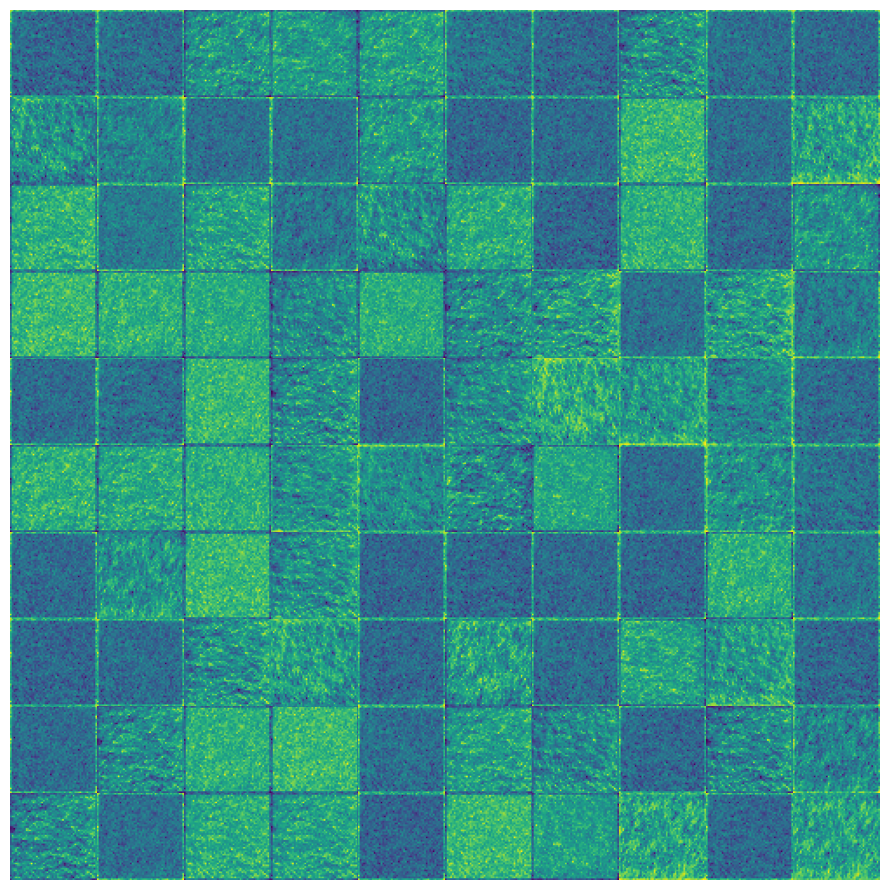

In [108]:
multiimshow(ratemaps, figsize=(10,10), normalize=False);

In [23]:
import numpy as np
velocities, init_pc_positions, labels, positions = dataset[0]

from SorscherRNN_cuda import SorscherRNN

model= SorscherRNN() # default parameters are fine

if torch.cuda.is_available():

    model = model.to('cuda')

# Demonstrate a a forward pass with the model for a single input

# its the first two elements (velocity and initial place cell activity) of a dataset instance

predictions = model(velocities, init_pc_positions)

print("predictions =", predictions.shape)

from original import SorscherRNN as vemund

model = vemund() # default parameters are fine

if torch.cuda.is_available():

    model = model.to('cuda')

# Demonstrate a a forward pass with the model for a single input

# its the first two elements (velocity and initial place cell activity) of a dataset instance

predictions2 = model(velocities, init_pc_positions)

print("predictions =", predictions2.shape)

print(np.sum(predictions2.detach().cpu().numpy() - predictions.detach().cpu().numpy()))

predictions = torch.Size([1, 20, 512])
predictions = torch.Size([1, 20, 512])
-4.451553e-08
